# Stroke Prediction 
According to the World Health Organization (WHO), strokes are the second leading cause of death globally, accounting for 11% of total deaths. In this project, we will use this [dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download) to determine whether or not a patient is likely to get a stroke based on various features such as gender, age, various diseases, smoking status, etc. Each row represents a single patient.

## Library Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style='darkgrid')
%config InlineBackend.figure_format = 'retina'
from tqdm.notebook import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

## EDA and Visualization

In [2]:
df = pd.read_csv('Datasets/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We won't need the `id` column as that does not tell us anything about whether or not the person could have a stroke or not. We will drop this column below.

In [3]:
df = df.drop(columns = ['id'])

Let's take a look at the distribution of the target variable, `stroke`. 

In [4]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Looks like we will be dealing with class imbalance issues, as the '1's represent only about 5% of the data. We may want to deal with this later with some sort of undersampling technique.

Let's also take a look at the null values and distributions of our data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
df.loc[:,['age', 'avg_glucose_level', 'bmi', 'stroke']].describe()

,age,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,106.147677,28.893237,0.048728
std,22.612647,45.283560,7.854067,0.215320
min,0.080000,55.120000,10.300000,0.000000
25%,25.000000,77.245000,23.500000,0.000000
50%,45.000000,91.885000,28.100000,0.000000
75%,61.000000,114.090000,33.100000,0.000000
max,82.000000,271.740000,97.600000,1.000000


> Looking at the outputs of `df.info` and `df.decsribe`, it appears that only one column contains null values--the `bmi` column. We will impute this column after splitting the data. 
> We also notice that the dataframe assumed `hypertension` and `heart_disease` were numerical columns, but these are in fact Boolean variables. Let's change these columns before proceeding. 

In [7]:
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   bool   
 3   heart_disease      5110 non-null   bool   
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: bool(2), float64(3), int64(1), object(5)
memory usage: 369.4+ KB


Let's also check if there are any strange categorical values.

In [8]:
for col in ['gender','hypertension','heart_disease','ever_married', 'work_type', 'Residence_type','smoking_status']:
    print(df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
False    4612
True      498
Name: hypertension, dtype: int64
False    4834
True      276
Name: heart_disease, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


There is a single record with a gender of "Other". To simplify this column, we will change this single record to the majority gender of Female.

In [9]:
df['gender'].replace(to_replace={'Other':'Female'}, inplace=True)
df['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

Now let's take a look at some basic histograms to understand the distributions of the numerical features for this data. 

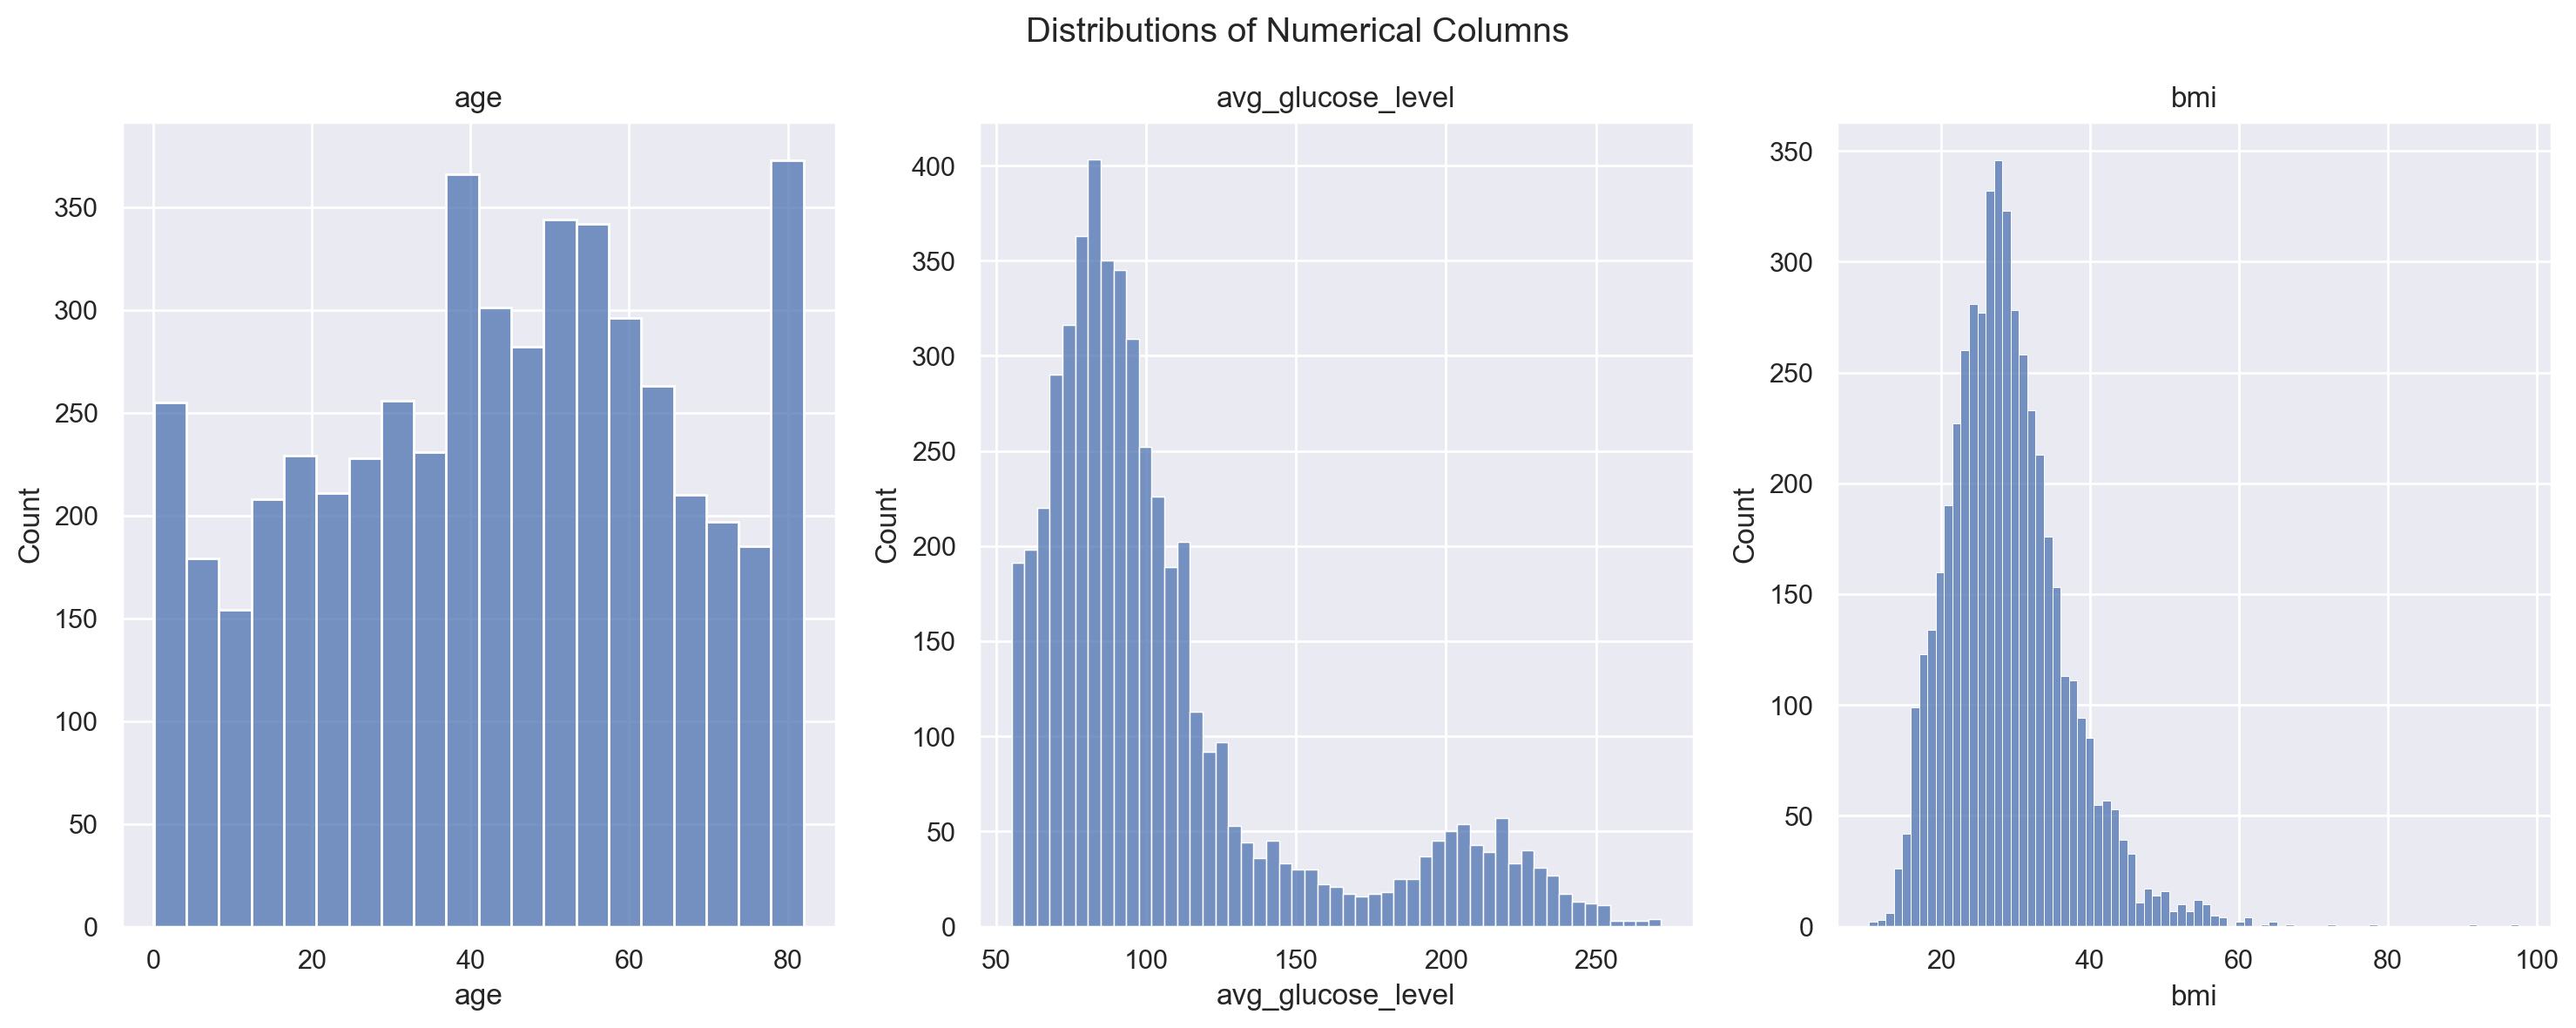

In [10]:
fig, ax = plt.subplots(1,3, figsize = (18, 6))
ax = ax.flatten()
fig.suptitle('Distributions of Numerical Columns')

for i, col in zip(range(6), ['age', 'avg_glucose_level', 'bmi']):
    sns.histplot(x = col, data=df, ax=ax[i])
    ax[i].set_title(f'{col}')

The `avg_glucose_level` and `bmi` columns appear to be right-skewed. We may want to normalize our numerical features (after splitting the data) by using StandardScaler so that they do not have an adverse effect on any linear models we want to try. 

Now let's take a look at how the categorical variables affect the target variable using main effect plots. 

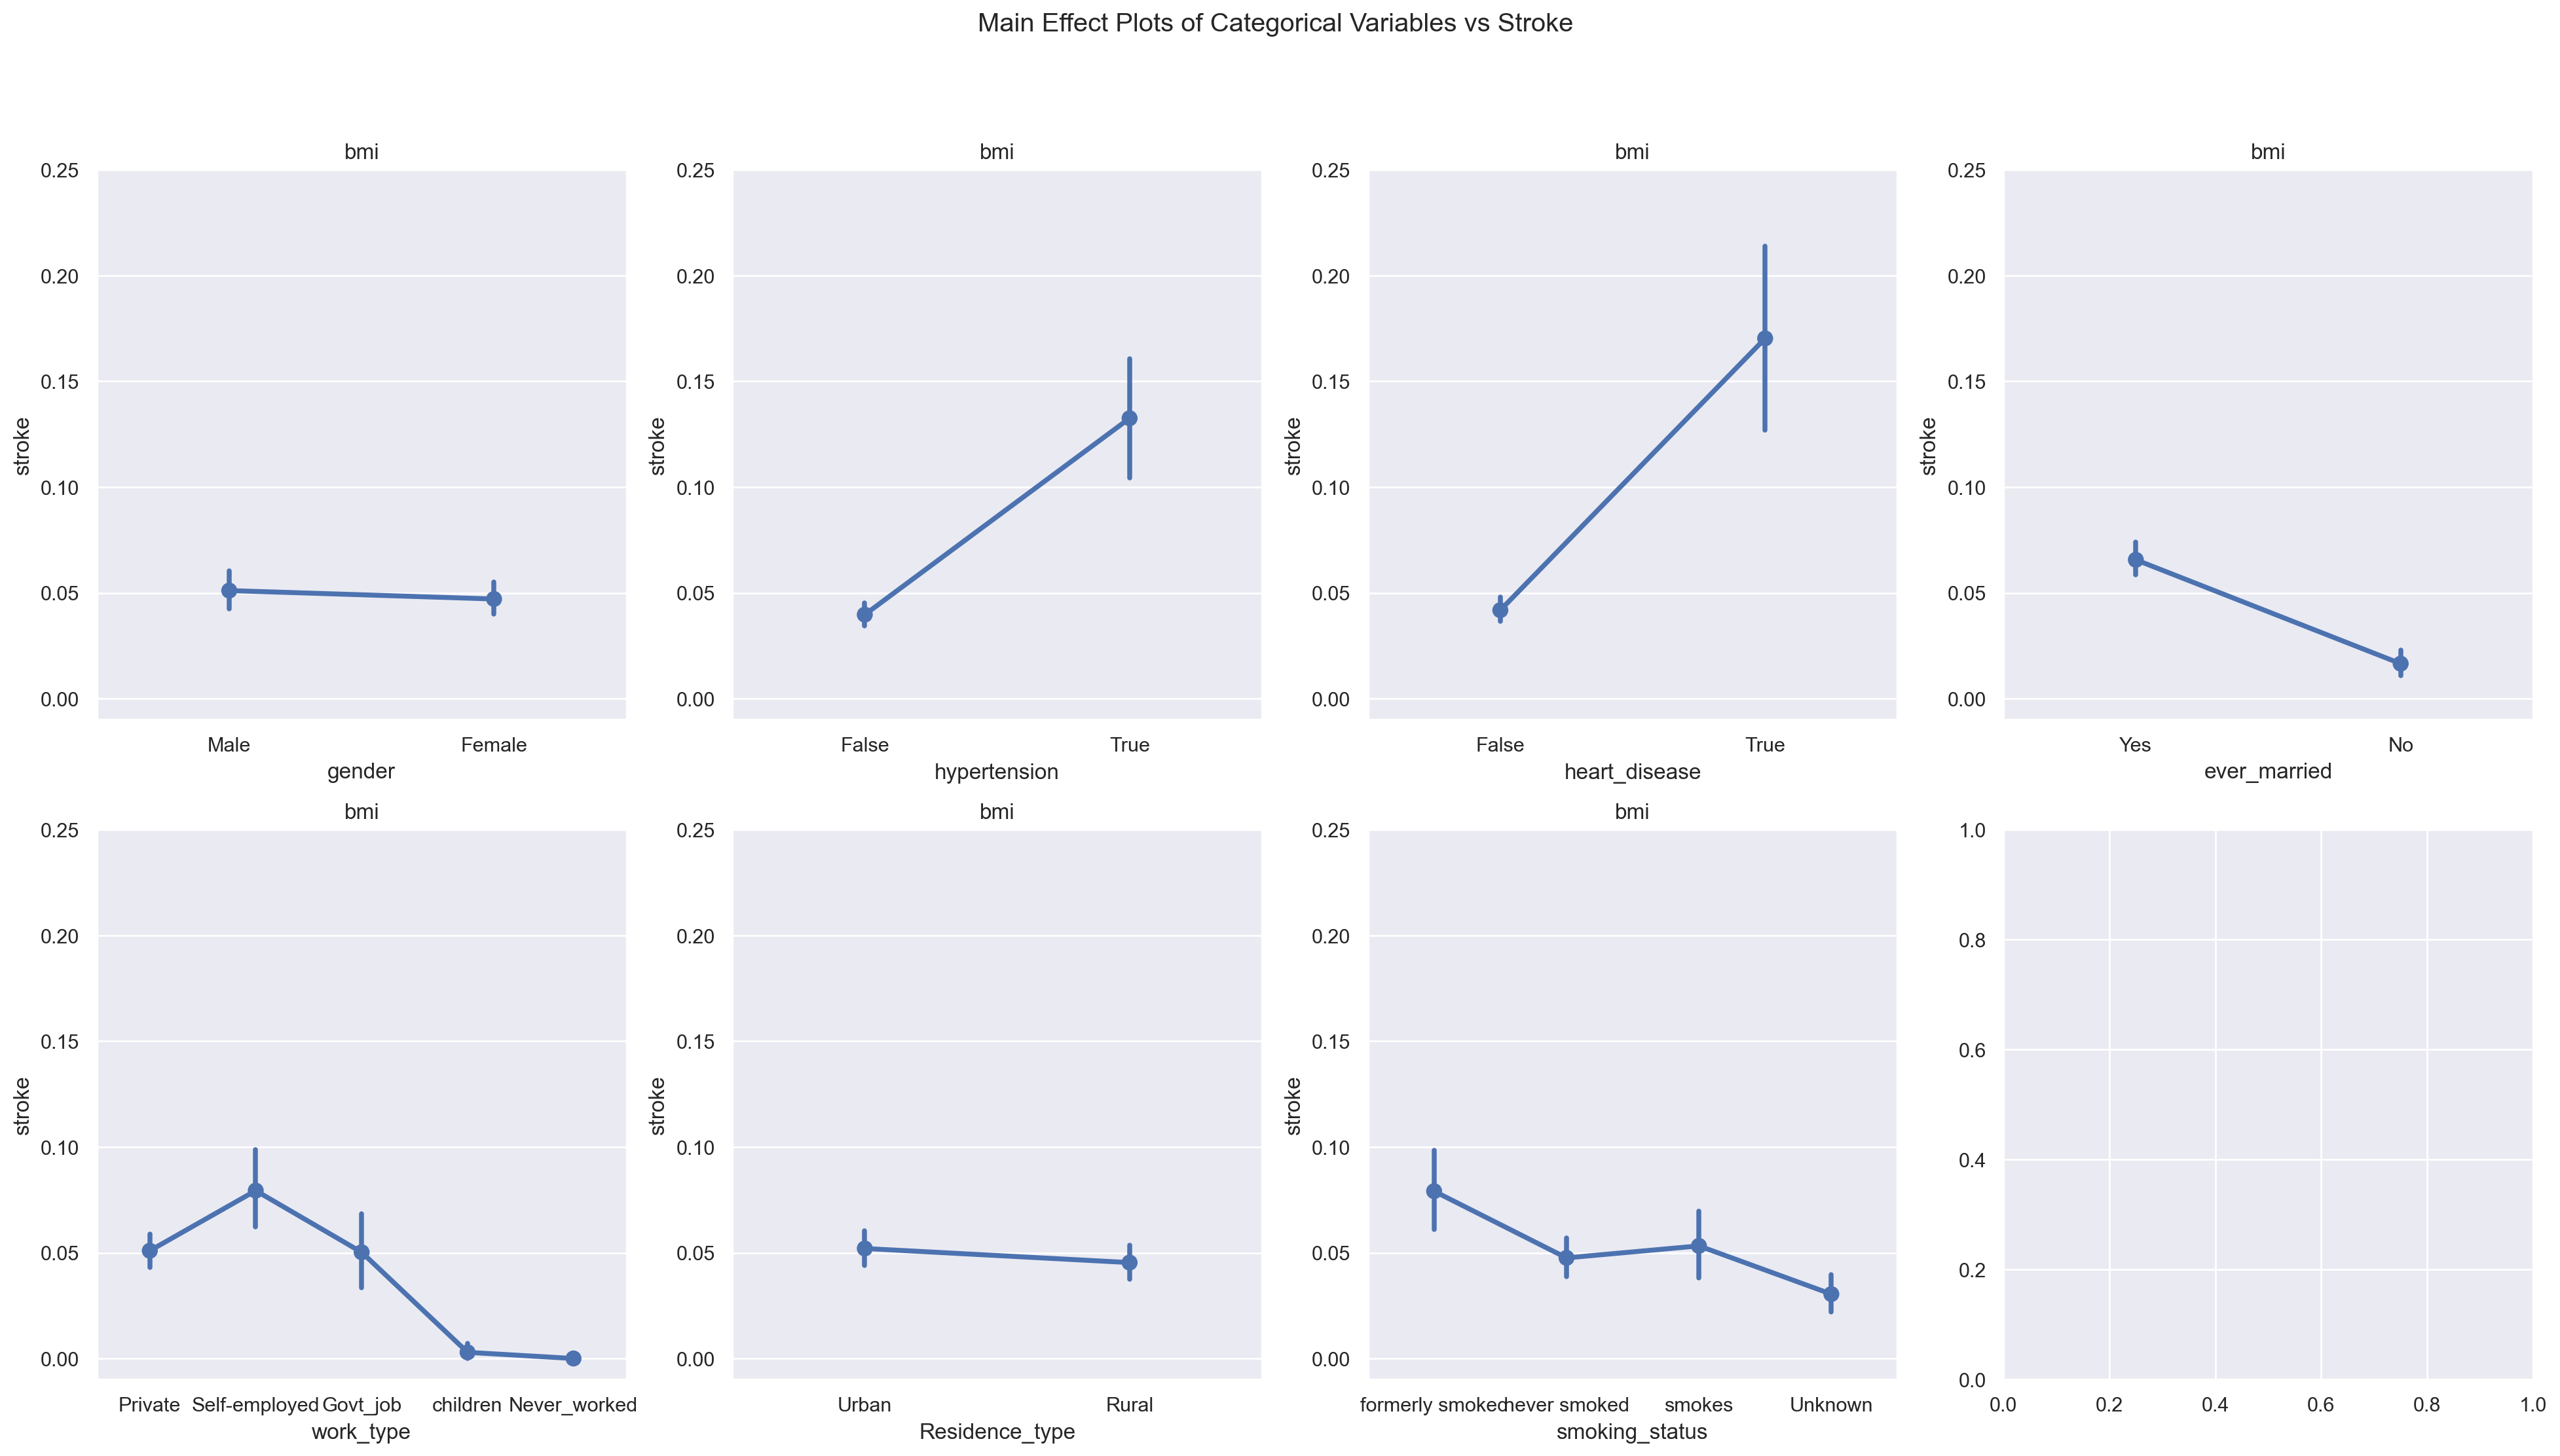

In [11]:
fig, ax = plt.subplots(2,4, figsize = (24,12))
ax = ax.flatten()
fig.suptitle('Main Effect Plots of Categorical Variables vs Stroke')

for i, cat in zip(range(7),['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',	'Residence_type', 'smoking_status']):
    sns.pointplot(x=cat, y='stroke', data=df, ax=ax[i])
    ax[i].set_ylim([-0.01, 0.25])
    ax[i].set_title(f'{col}')

Based on the main effect plots above, which have all been slightly altered such that they all have the same y-axis, it seems that every categorical variable has a notable effect on the target except for `Residence_type`. We may consider dropping this column as it does not significantly help explain the target variable. 

In the case of linear models, we will also want to use dummy variables for our categorical variables so that the linear model interprets them correctly. Let's save it in a separate dataframe so that we can leave the data as is for our other models.

In [12]:
linear_df = pd.get_dummies(df)

## Handling Class Imbalance
As we mentioned earlier, there is a 5% to 95% class imbalance between those who had a stroke and those who didn't, respectively. We will attempt to remedy this with undersampling using the `imblearn` library. 

In [13]:
x_lin = linear_df.drop(columns = ['stroke'])
y_lin = linear_df['stroke']

In [14]:
# Undersampling the 0s
RUS = RandomUnderSampler()
x_under, y_under = RUS.fit_resample(x_lin, y_lin)
y_under.value_counts()

0    249
1    249
Name: stroke, dtype: int64

## Data Splitting, Cleaning (Linear Models)

In [15]:
x_train_val_lin, x_test_lin, y_train_val_lin, y_test_lin = train_test_split(x_under, y_under, stratify = y_under, random_state = 42)

In [16]:
x_train_val_lin

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
384,71.0,False,False,263.32,38.7,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0
22,25.0,False,False,68.07,18.6,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1
457,78.0,True,False,134.80,33.6,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0
373,72.0,False,False,219.91,NaN,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
472,81.0,False,False,70.30,25.8,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,53.0,False,False,211.03,34.2,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0
424,72.0,True,False,185.49,37.1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0
322,63.0,False,False,228.56,27.4,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
218,78.0,False,False,93.85,22.7,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0


In [17]:
# Imputing BMI column with median in train and test sets
bmi_med = x_train_val_lin['bmi'].median()
x_train_val_lin['bmi'] = x_train_val_lin['bmi'].fillna(bmi_med)
x_test_lin['bmi'] = x_test_lin['bmi'].fillna(bmi_med)
x_train_val_lin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 384 to 226
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             373 non-null    float64
 1   hypertension                    373 non-null    bool   
 2   heart_disease                   373 non-null    bool   
 3   avg_glucose_level               373 non-null    float64
 4   bmi                             373 non-null    float64
 5   gender_Female                   373 non-null    uint8  
 6   gender_Male                     373 non-null    uint8  
 7   ever_married_No                 373 non-null    uint8  
 8   ever_married_Yes                373 non-null    uint8  
 9   work_type_Govt_job              373 non-null    uint8  
 10  work_type_Never_worked          373 non-null    uint8  
 11  work_type_Private               373 non-null    uint8  
 12  work_type_Self-employed         37

## Linear Models
### Logistic Regression
Now the data is ready for the model. Let's begin with a simple logistic regression model and see how it performs. We will perform ten-fold cross-validation to stabilize the test statistics.

In [18]:
# Cross validation 
kf = KFold(n_splits=10)
linear_metrics_df = pd.DataFrame(columns = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

for train_index, test_index in kf.split(x_train_val_lin):
    X_train, X_test = x_train_val_lin.iloc[train_index], x_train_val_lin.iloc[test_index]
    Y_train, Y_test = y_train_val_lin.iloc[train_index], y_train_val_lin.iloc[test_index]
    X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].median()) # Imputing nulls with the median
    X_test['bmi'] = X_test['bmi'].fillna(X_train['bmi'].median())
    ct = ColumnTransformer([('scaler', StandardScaler(), ['age', 'avg_glucose_level', 'bmi'])], remainder = 'passthrough')
    ct.fit(X_train)
    X_train = ct.transform(X_train)
    X_test = ct.transform(X_test)
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    Y_preds = lr.predict(X_test)
    linear_metrics_df.loc[len(linear_metrics_df.index)] = [accuracy_score(Y_preds, Y_test),
                                                           roc_auc_score(Y_preds, Y_test), 
                                                           precision_score(Y_preds, Y_test), 
                                                           recall_score(Y_preds, Y_test), 
                                                           f1_score(Y_preds, Y_test)]
# Cross-validated metrics                                                           
linear_metrics_df.mean(axis = 0)

accuracy     0.779730
roc_auc      0.782546
precision    0.812389
recall       0.756908
f1           0.779289
dtype: float64

In [19]:
# Checking test set performance
x_train_val_lin_imputed = x_train_val_lin.copy()
x_test_lin_imputed = x_test_lin.copy()

x_train_val_lin_imputed['bmi'] = x_train_val_lin['bmi'].fillna(x_train_val_lin['bmi'].median())
x_test_lin_imputed['bmi'] = x_test_lin['bmi'].fillna(x_train_val_lin['bmi'].median())
ct = ColumnTransformer([('scaler', StandardScaler(), ['age', 'avg_glucose_level', 'bmi'])], remainder = 'passthrough')
ct.fit(x_train_val_lin_imputed)
x_train_scaled = ct.transform(x_train_val_lin_imputed)
x_test_scaled = ct.transform(x_test_lin_imputed)

lr = LogisticRegression()
lr.fit(x_train_scaled, y_train_val_lin)
preds = lr.predict(x_test_scaled)

print('Test accuracy:', accuracy_score(preds, y_test_lin))
print('ROC AUC Score:', roc_auc_score(preds, y_test_lin))
print('Precision:', precision_score(preds, y_test_lin))
print('Recall:', recall_score(preds, y_test_lin))
print('F1:', f1_score(preds, y_test_lin))

Test accuracy: 0.768
ROC AUC Score: 0.7713509316770186
Precision: 0.8225806451612904
Recall: 0.7391304347826086
F1: 0.7786259541984734


The Logistic Regression model performed fairly well, with almost all metrics reaching above 0.75 on the train and test sets.

### Linear Support Vector Machines 
Now we will try Linear SVM, or Linear Support Vector Machine, models. This is different from traditional linear or logistic regression models in that the algorithm tries to find the best hyperplane that can separate data into different classes. This hyperplane is chosen so that it maximizes the margin between the hyperplane and the closest data points from each class, or the support vectors. In simpler terms, the model tries to find a line that separates the data into two groups, with the largest possible margin between the groups. 

In [20]:
# Cross validation
kf = KFold(n_splits=10)
linear_metrics_df = pd.DataFrame(columns = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

for train_index, test_index in kf.split(x_train_val_lin):
    X_train, X_test = x_train_val_lin.iloc[train_index], x_train_val_lin.iloc[test_index]
    Y_train, Y_test = y_train_val_lin.iloc[train_index], y_train_val_lin.iloc[test_index]
    X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].median()) # Imputing nulls with the median
    X_test['bmi'] = X_test['bmi'].fillna(X_train['bmi'].median())
    ct = ColumnTransformer([('scaler', StandardScaler(), ['age', 'avg_glucose_level', 'bmi'])], remainder = 'passthrough')
    ct.fit(X_train)
    X_train = ct.transform(X_train)
    X_test = ct.transform(X_test)
    svc = SVC(kernel = 'rbf')
    svc.fit(X_train, Y_train)
    preds = svc.predict(X_test)
    linear_metrics_df.loc[len(linear_metrics_df.index)] = [accuracy_score(preds, Y_test),
                                                           roc_auc_score(preds, Y_test), 
                                                           precision_score(preds, Y_test), 
                                                           recall_score(preds, Y_test), 
                                                           f1_score(preds, Y_test)]
# Cross-validated metrics
linear_metrics_df.mean(axis = 0)

accuracy     0.755903
roc_auc      0.764667
precision    0.815468
recall       0.732085
f1           0.765446
dtype: float64

In [21]:
# Test set performance
svc = SVC(kernel = 'rbf')
svc.fit(x_train_scaled, y_train_val_lin)
preds = svc.predict(x_test_scaled)

print('Test accuracy:', accuracy_score(preds, y_test_lin))
print('ROC AUC Score:', roc_auc_score(preds, y_test_lin))
print('Precision:', precision_score(preds, y_test_lin))
print('Recall:', recall_score(preds, y_test_lin))
print('F1:', f1_score(preds, y_test_lin))

Test accuracy: 0.728
ROC AUC Score: 0.7318181818181818
Precision: 0.7903225806451613
Recall: 0.7
F1: 0.7424242424242423


The Linear SVM model performed slightly worse than the Logistic Regression model. This might indicate that the data is not easily linearly separable, as Linear SVM models tend to work better with linearly separable data. Let's move on to tree-based models.

## Tree-Based Models
Continuing from the original dataset (before the alterations for the linear models), we will prepare the data for tree-based models, which do not require scaling as they are not distance-based models.

In [22]:
x = df.drop(columns = ['stroke'])
y = df['stroke']

In [23]:
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(x[col].value_counts())

Female    2995
Male      2115
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [24]:
# Handling class imbalance again with similar ratios as in the linear models section
RUS = RandomUnderSampler()
x_under, y_under = RUS.fit_resample(x, y)
y_under.value_counts()

0    249
1    249
Name: stroke, dtype: int64

In [25]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x_under, y_under, stratify = y_under, shuffle = True, random_state = 42)

Now that our data is prepped for the tree-based models, we can run it through each of them and see how they perform. We will begin with the DecisionTreeClassifier.

In [26]:
# Checking all tree-based model performances
metrics_dict = {}
for tree_model in ['Decision Tree', 'Random Forest', 'Gradient Boost']:
    if tree_model == 'Decision Tree':
        model = DecisionTreeClassifier()
    elif tree_model == 'Random Forest':
        model = RandomForestClassifier()
    elif tree_model == 'Gradient Boost':
        model = GradientBoostingClassifier()
    
    metrics_dict[tree_model] = pd.DataFrame(columns = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
    kf = KFold(n_splits = 10)

    # Cross validation loop
    for train_index, test_index in tqdm(kf.split(x_train_val)):
        X_train, X_test = x_train_val.iloc[train_index], x_train_val.iloc[test_index]
        Y_train, Y_test = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
        X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].median()) # Imputing nulls with the median
        X_test['bmi'] = X_test['bmi'].fillna(X_train['bmi'].median())
        for cat in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
            le = LabelEncoder()
            le.fit(X_train[cat])
            x_test[cat] = x_test[cat].where(x_test[cat].isin(le.classes_), other=-1)
            le.classes_ = np.append(le.classes_, -1)
            X_train[cat] = le.transform(X_train[cat])
            X_test[cat] = le.transform(X_test[cat])
        model.fit(X_train, Y_train)
        Y_preds = model.predict(X_test)
        metrics_dict[tree_model].loc[len(metrics_dict[tree_model].index)] = [accuracy_score(Y_preds, Y_test),
                                                            roc_auc_score(Y_preds, Y_test), 
                                                            precision_score(Y_preds, Y_test), 
                                                            recall_score(Y_preds, Y_test), 
                                                            f1_score(Y_preds, Y_test)]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
# Outputting the cross-validated metrics for each tree-based model
for model_type, metrics_df in metrics_dict.items():
    print(f'{model_type} Metrics:')
    print(metrics_df.mean(axis = 0), '\n')

Decision Tree Metrics:
accuracy     0.705121
roc_auc      0.708963
precision    0.700623
recall       0.720067
f1           0.702169
dtype: float64 

Random Forest Metrics:
accuracy     0.729018
roc_auc      0.730054
precision    0.782888
recall       0.711478
f1           0.741282
dtype: float64 

Gradient Boost Metrics:
accuracy     0.729018
roc_auc      0.728291
precision    0.758032
recall       0.722429
f1           0.735964
dtype: float64 



## Conclusion
In general, it seems that the linear models performed better than the tree based models. This might be attributed to the fact that, due to the undersampling, the dataset became fairly small. Tree-based models tend to overfit on small datasets, and in these situations linear models tend to shine, as they handle smaller datasets better. We could take a different approach and do oversampling in order to see how the tree-based models might perform with more available data and more "1s", but that also introduces artificial/synthetic data, which may not be ideal, especially in the medical field. Another solution would be to collect more data on patients that actually had a stroke, but that can be costly in the real world. One method that may be worth exploring in a future project is repeated undersampling, where you undersample the majority repeatedly, using different values for the `random_state` parameter in the `RandomUnderSampler` object, fit a model on each of the new samples, obtain each model's performance metric, and then take the average across all of the undersamples. This is somewhat like cross-validation but instead you are changing the "0"s of your training and test set every time while keeping the "1"s the same.